# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.2 MB/s 


In [ ]:
# Import packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import image_dataset_from_directory, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.optimizers import Adam
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
train_path = "/content/drive/MyDrive/LHL_Final_Project/Data1/archive/Face Mask Dataset/Train"
validation_path = "/content/drive/MyDrive/LHL_Final_Project/Data1/archive/Face Mask Dataset/Validation"
test_path = "/content/drive/MyDrive/LHL_Final_Project/Data1/archive/Face Mask Dataset/Test"

In [ ]:
train_ds = image_dataset_from_directory(directory=train_path, class_names=['WithoutMask', 'WithMask'], label_mode='categorical', seed=22)
validation_ds = image_dataset_from_directory(directory=validation_path, class_names=['WithoutMask', 'WithMask'], label_mode='categorical', seed=22)
test_ds = image_dataset_from_directory(directory=test_path, class_names=['WithoutMask', 'WithMask'], label_mode='categorical', seed=22)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [ ]:
# Extract test images and labels
x_test = []
y_true = []
for x, y in test_ds.unbatch():
  x_test.append(x.numpy())
  y_true.append(y.numpy())

x_test = np.array(x_test)
y_true = np.array(y_true)

def flat(x):
  if x[0] == 1:
    return 0
  else:
    return 1

y_true = np.apply_along_axis(flat, 1, y_true1)

In [ ]:
clear_session()

# Baseline Model

In [ ]:
# base model
input_dim = (256, 256, 3)
base_model = Sequential()
base_model.add(Rescaling(1./255, input_shape=input_dim))
base_model.add(Flatten())
base_model.add(Dense(256, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dropout(0.2))
base_model.add(Dense(2, activation='softmax'))

base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               50331904  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [ ]:
base_history = base_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
313/313 [==============================] - 599s 2s/step - loss: 2.9554 - accuracy: 0.6813 - val_loss: 0.4371 - val_accuracy: 0.8737
Epoch 2/10
313/313 [==============================] - 20s 63ms/step - loss: 0.5869 - accuracy: 0.6669 - val_loss: 0.4997 - val_accuracy: 0.7775
Epoch 3/10
313/313 [==============================] - 20s 64ms/step - loss: 0.5664 - accuracy: 0.6833 - val_loss: 0.4089 - val_accuracy: 0.8600
Epoch 4/10
313/313 [==============================] - 20s 63ms/step - loss: 0.5820 - accuracy: 0.6695 - val_loss: 0.3515 - val_accuracy: 0.9112
Epoch 5/10
313/313 [==============================] - 20s 63ms/step - loss: 0.5569 - accuracy: 0.6895 - val_loss: 0.3434 - val_accuracy: 0.9162
Epoch 6/10
313/313 [==============================] - 20s 63ms/step - loss: 0.5459 - accuracy: 0.6971 - val_loss: 0.4125 - val_accuracy: 0.8575
Epoch 7/10
313/313 [==============================] - 20s 63ms/step - loss: 0.5617 - accuracy: 0.6856 - val_loss: 0.3394 - val_accuracy: 

# CNN model

In [ ]:
clear_session()

In [ ]:
# CNN
input_dim = (256, 256, 3)
cnn_model = Sequential()
cnn_model.add(Rescaling(1./255, input_shape=input_dim))
cnn_model.add(RandomFlip('horizontal'))
cnn_model.add(RandomRotation(0.2))
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_dim))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      1

In [ ]:
history_cnn = cnn_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
313/313 [==============================] - 25s 71ms/step - loss: 0.2605 - accuracy: 0.9054 - val_loss: 0.1373 - val_accuracy: 0.9588
Epoch 2/10
313/313 [==============================] - 22s 70ms/step - loss: 0.1595 - accuracy: 0.9434 - val_loss: 0.1079 - val_accuracy: 0.9712
Epoch 3/10
313/313 [==============================] - 22s 69ms/step - loss: 0.1362 - accuracy: 0.9520 - val_loss: 0.1077 - val_accuracy: 0.9725
Epoch 4/10
313/313 [==============================] - 22s 70ms/step - loss: 0.1312 - accuracy: 0.9545 - val_loss: 0.0835 - val_accuracy: 0.9775
Epoch 5/10
313/313 [==============================] - 22s 69ms/step - loss: 0.1202 - accuracy: 0.9593 - val_loss: 0.0694 - val_accuracy: 0.9787
Epoch 6/10
313/313 [==============================] - 22s 69ms/step - loss: 0.1052 - accuracy: 0.9609 - val_loss: 0.0951 - val_accuracy: 0.9688
Epoch 7/10
313/313 [==============================] - 22s 69ms/step - loss: 0.0971 - accuracy: 0.9656 - val_loss: 0.0645 - val_accuracy:

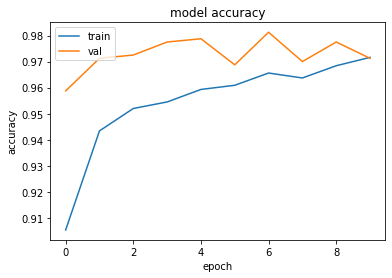

In [ ]:
# Plot accuracy and loss
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

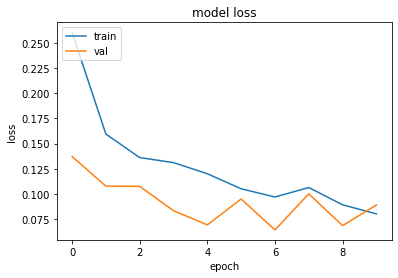

In [ ]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Evaluation

In [ ]:
cnn_model.evaluate(test_ds)

31/31 [==============================] - 2s 48ms/step - loss: 0.0960 - accuracy: 0.9657


[0.09604650735855103, 0.9657257795333862]

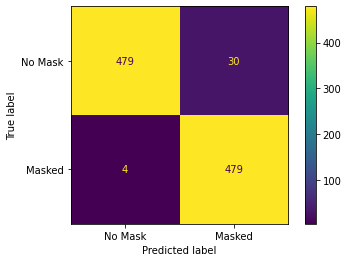

In [ ]:
# Confusion Matrix
def transform(x):
  if x[0] >= x[1]:
    return 0
  else:
    return 1

y_pred = cnn_model.predict(x_test)
y_pred = np.apply_along_axis(transform, 1, y_pred)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Mask', 'Masked']).plot()

In [ ]:
print(classification_report(y_true, y_pred, target_names=['No Mask', 'Masked']))

              precision    recall  f1-score   support

     No Mask       0.99      0.94      0.97       509
      Masked       0.94      0.99      0.97       483

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992



In [ ]:
 cnn_model.save("/content/drive/MyDrive/LHL_Final_Project/mask_detector_cnn.h5")

# Transfer learning with VGG19

In [ ]:
clear_session()

In [ ]:
# Data augmentation
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

In [ ]:
# Instantiate base model
base_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3),
    pooling='avg'
)

In [ ]:
# Freeze the pre-trained parameters
base_model.trainable = False

In [ ]:
inputs = Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='softmax')(x)
vgg_model = keras.Model(inputs, outputs)

vgg_model.compile(optimizer=Adam(learning_rate=0.001/10), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
init_epochs = 10
history_vgg = vgg_model.fit(train_ds, validation_data=validation_ds, epochs=init_epochs)

Epoch 1/10
313/313 [==============================] - 37s 114ms/step - loss: 0.7255 - accuracy: 0.7932 - val_loss: 0.2812 - val_accuracy: 0.9375
Epoch 2/10
313/313 [==============================] - 36s 113ms/step - loss: 0.2995 - accuracy: 0.9310 - val_loss: 0.1412 - val_accuracy: 0.9625
Epoch 3/10
313/313 [==============================] - 36s 113ms/step - loss: 0.1804 - accuracy: 0.9581 - val_loss: 0.0947 - val_accuracy: 0.9787
Epoch 4/10
313/313 [==============================] - 36s 113ms/step - loss: 0.1386 - accuracy: 0.9668 - val_loss: 0.0741 - val_accuracy: 0.9812
Epoch 5/10
313/313 [==============================] - 36s 113ms/step - loss: 0.1123 - accuracy: 0.9737 - val_loss: 0.0603 - val_accuracy: 0.9850
Epoch 6/10
313/313 [==============================] - 36s 113ms/step - loss: 0.0984 - accuracy: 0.9749 - val_loss: 0.0505 - val_accuracy: 0.9912
Epoch 7/10
313/313 [==============================] - 36s 113ms/step - loss: 0.0848 - accuracy: 0.9782 - val_loss: 0.0418 - val_ac

In [ ]:
vgg_model.evaluate(test_ds)

31/31 [==============================] - 4s 104ms/step - loss: 0.0298 - accuracy: 0.9899


[0.0298449769616127, 0.9899193644523621]

Fine-tune

In [ ]:
# Unfreeze base model
base_model.trainable = True

In [ ]:
# Check layers
len(base_model.layers)

23

In [ ]:
# Fine tune from this layer onwards
fine_tune_at = 20

In [ ]:
# Freeze all layers before first fine tune layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# Re-compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.001/100), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
fine_tune_epochs = 10
total_epochs =  init_epochs + fine_tune_epochs

history_vggfine = vgg_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_vgg.epoch[-1],
                         validation_data=validation_ds)

Epoch 10/20
313/313 [==============================] - 38s 116ms/step - loss: 0.0475 - accuracy: 0.9876 - val_loss: 0.0165 - val_accuracy: 0.9962
Epoch 11/20
313/313 [==============================] - 36s 115ms/step - loss: 0.0270 - accuracy: 0.9928 - val_loss: 0.0118 - val_accuracy: 0.9962
Epoch 12/20
313/313 [==============================] - 36s 115ms/step - loss: 0.0224 - accuracy: 0.9936 - val_loss: 0.0114 - val_accuracy: 0.9962
Epoch 13/20
313/313 [==============================] - 36s 115ms/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 0.0097 - val_accuracy: 0.9975
Epoch 14/20
313/313 [==============================] - 36s 114ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0072 - val_accuracy: 0.9962
Epoch 15/20
313/313 [==============================] - 36s 114ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0113 - val_accuracy: 0.9975
Epoch 16/20
313/313 [==============================] - 36s 114ms/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0085 -

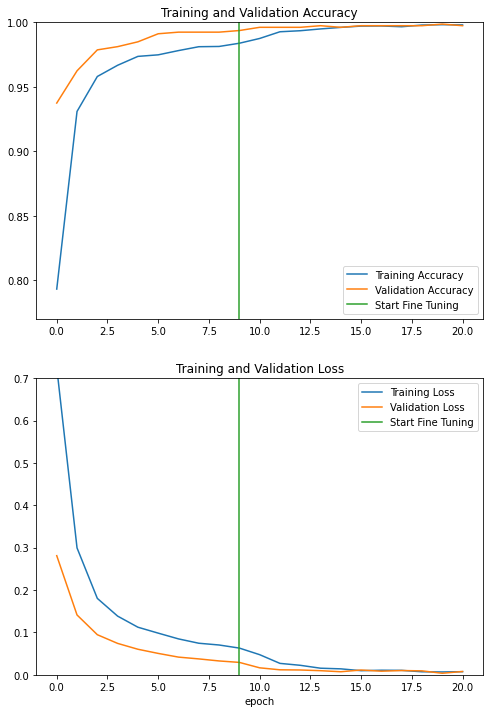

In [ ]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(history_vgg.history['accuracy'] + history_vggfine.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'] + history_vggfine.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0.77, 1])
plt.plot([init_epochs-1,init_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_vgg.history['loss'] + history_vggfine.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'] + history_vggfine.history['val_loss'], label='Validation Loss')
plt.ylim([0, 0.7])
plt.plot([init_epochs-1,init_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_model.evaluate(test_ds)

31/31 [==============================] - 4s 104ms/step - loss: 0.0053 - accuracy: 0.9980


[0.005281086079776287, 0.9979838728904724]

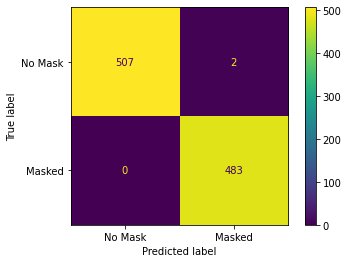

In [ ]:
# Confusion matrix
y_pred = vgg_model.predict(x_test)
y_pred = np.apply_along_axis(transform, 1, y_pred)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Mask', 'Masked']).plot()

In [ ]:
print(classification_report(y_true, y_pred, target_names=['No Mask', 'Masked']))

              precision    recall  f1-score   support

     No Mask       1.00      1.00      1.00       509
      Masked       1.00      1.00      1.00       483

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



In [ ]:
vgg_model.save("/content/drive/MyDrive/LHL_Final_Project/mask_detector_vgg19.h5")

# Face detection & Mask detection

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/LHL_Final_Project/mask_detector_vgg19.h5")

In [ ]:
def mask_detect(img):
  img_ary = img_to_array(img)
  detector = MTCNN()
  faces = detector.detect_faces(img_ary)
  plt.figure(figsize=(15, 12))
  plt.imshow(img)
  ax = plt.gca()
  for face in faces:
    x1, y1, width, height = face['box']
    x2, y2 = x1+width, y1+height

    pred = model.predict(smart_resize(img_ary[y1:y2, x1:x2], (256, 256)).reshape(1, 256, 256, 3))
    print(pred)
    if pred[0][0] >= pred[0][1]:
      txt = 'No Mask'
      color = 'red'
    else:
      txt = 'Masked'
      color = 'lime'
    
    rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=2)
    ax.add_patch(rect)
    ax.text(x1, y1-2, txt, fontsize=24, fontweight='bold', color=color)
  plt.show()

[[1.1489697e-09 1.0000000e+00]]
[[0.03219311 0.96780694]]


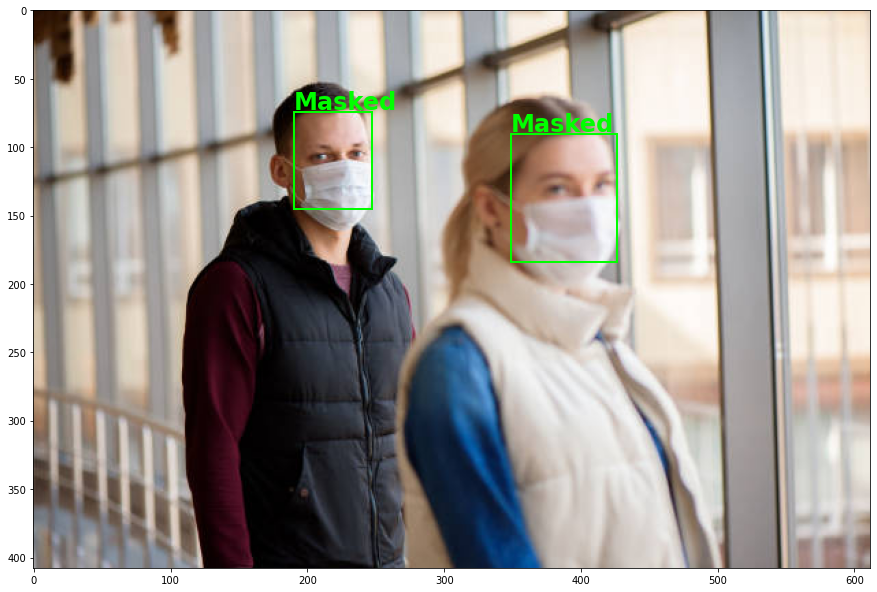

AxesImage(135,155.16;837x558)


In [ ]:
path1 = "/content/drive/MyDrive/LHL_Final_Project/testing images/2-mixed2.jpg"
path2 = "/content/drive/MyDrive/LHL_Final_Project/testing images/2-mixed.jpg"
path3 = "/content/drive/MyDrive/LHL_Final_Project/testing images/2-both-masked.jpg"
img = load_img(path1)
mask_detect(img)

img = load_img(path2)
mask_detect(img)

img = load_img(path3)
mask_detect(img)